In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import json
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import pearsonr
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from typing import Literal

In [135]:
# pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# Import Data

In [136]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)
data.shape

(1652, 44)

In [137]:
def replace_data(df):
    df.replace('N', np.nan, inplace=True)
    return df

In [138]:
column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

# Copy the initial dataset to apply transformations
def choose_labels(df, labels_chosen):
    df["Hardness_load"] = np.nan
    df["Nitrogen_concentration_residual"] = 0
    labels = df[labels_chosen]
    inputs = df.drop(columns=label_names + ['Weld_ID'])
    return inputs, labels

data_copy = data.copy()
data_copy= replace_data(data_copy)
inputs, outputs = choose_labels(df=data_copy, labels_chosen="Yield_strength")

# Infos

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carbon_concentration                  1652 non-null   float64
 1   Silicon_concentration                 1652 non-null   float64
 2   Manganese_concentration               1652 non-null   float64
 3   Sulphur_concentration                 1652 non-null   object 
 4   Phosphorus_concentration              1652 non-null   object 
 5   Nickel_concentration                  1652 non-null   object 
 6   Chromium_concentration                1652 non-null   object 
 7   Molybdenum_concentration              1652 non-null   object 
 8   Vanadium_concentration                1652 non-null   object 
 9   Copper_concentration                  1652 non-null   object 
 10  Cobalt_concentration                  1652 non-null   object 
 11  Tungsten_concentr

# Data Cleaning

## Structural Errors

In [140]:
i = 0
for column in data.columns:
    print(i)
    print(column)
    print(data[column].unique())
    i+=1

0
Carbon_concentration
[0.037  0.044  0.045  0.039  0.041  0.051  0.049  0.038  0.043  0.053
 0.046  0.048  0.074  0.075  0.076  0.068  0.081  0.079  0.078  0.069
 0.08   0.071  0.072  0.066  0.067  0.09   0.088  0.091  0.089  0.094
 0.086  0.04   0.047  0.052  0.05   0.054  0.073  0.077  0.07   0.062
 0.06   0.055  0.059  0.042  0.058  0.065  0.095  0.151  0.147  0.145
 0.061  0.035  0.1    0.12   0.099  0.093  0.101  0.096  0.097  0.03
 0.032  0.031  0.098  0.13   0.11   0.057  0.15   0.064  0.082  0.036
 0.125  0.105  0.115  0.1055 0.14   0.16   0.084  0.092  0.029  0.063
 0.18  ]
1
Silicon_concentration
[0.3   0.31  0.35  0.33  0.32  0.36  0.29  0.34  0.39  0.44  0.48  0.37
 0.51  0.57  0.27  0.45  0.24  0.41  0.46  0.43  0.42  0.52  0.54  0.18
 0.17  0.2   0.22  0.4   0.26  0.25  0.53  0.38  0.28  0.47  0.23  0.16
 0.62  0.68  0.59  0.7   0.56  0.5   0.58  0.66  0.63  0.67  0.61  0.21
 0.49  0.12  0.13  0.15  0.11  0.19  0.14  0.415 0.08  0.04  0.07  0.55
 0.9   0.8   1.14  0.95  

- Values < N: choose a random number < N, set the value to N
- Hardness: Cases like 158(Hv30) means a hardness of 158, measured with a 30 kgf load. When it is not specified, it means a default value was used.
- Nitrogen_concentration: Cases like '67tot33res' --> only use the part '67', split in two categories, one for '67' and one for '33'.
- Interpass_temperature: Cases like '150-200' means between 150 and 200

In [141]:
# Values < N
def replace_less_than_values(*, df, column, strategy):
    if df[column].any() and type(df[column].dropna().iloc[0]) == str:  # Check if the column contains string values:
        new_column = column + '_<'  # Create a new column name
        df[new_column] = np.nan  # Create a new column to store the boolean values
        
        # Apply the transformation using .loc to avoid SettingWithCopyWarning
        mask = df[column].apply(lambda x: isinstance(x, str))
        df.loc[mask, column + '_<'] = df.loc[mask, column].str.contains('<')
        df.loc[mask, column] = df.loc[mask, column].replace('<', '', regex=True)
        
        # Take a random value between 0 and the value of the column
        if strategy=='random':
            df.loc[df[new_column] == True, column] = df.loc[df[new_column] == True, column].apply(lambda x: np.random.uniform(0, float(x)))
        elif strategy=='half':
            df.loc[df[new_column] == True, column] = df.loc[df[new_column] == True, column].apply(lambda x: float(x)/2)

        df.drop(column + '_<', axis=1, inplace=True)
    return df

# Values like 158(Hv30) or 67tot33res
def split_res_values(value, pattern):
    if isinstance(value, str) and pattern in value:
        # Looking for two numbers in the string 
        numbers = re.findall(r'\d+', value)
        if len(numbers) > 1:
            return float(numbers[0]), float(numbers[1])
        else:
            return float(numbers[0]), np.nan  # If only one number is before "res"
    else:
        try:
            return float(value), np.nan  # If there is no "res", return NaN
        except ValueError:
            return np.nan, np.nan

# Values like 150 - 200
def process_interpass_temperature(value):
        if isinstance(value, str) and '-' in value:
            # Split the range, convert to integers, and calculate the mean
            low, high = map(int, value.split('-'))
            return int((low + high) / 2)
        else:
            # Try converting the value to int, or return NaN if not possible
            try:
                return int(value)
            except (ValueError, TypeError):
                return np.nan
            
# Handling columns with two numerical values 
def process_string_values(*, inputs, outputs, strategy, labels_chosen):
    for column in inputs.columns:
        inputs = replace_less_than_values(df=inputs, column=column, strategy=strategy)
    inputs['Nitrogen_concentration'], inputs['Nitrogen_concentration_residual'] =  zip(*inputs['Nitrogen_concentration'].apply(lambda x:split_res_values(x, 'res')))
    if 'Hardness' in labels_chosen:
        outputs['Hardness'], outputs['Hardness_load'] =  zip(*outputs['Hardness'].apply(lambda x:split_res_values(x, 'Hv')))
    inputs['Interpass_temperature'] = inputs['Interpass_temperature'].apply(process_interpass_temperature)
    return inputs, outputs

data_copy, _ = process_string_values(inputs=inputs, outputs=outputs, strategy='random', labels_chosen="Yield_strength")

/var/folders/nc/9qrt440j5_qfd7mpy2693qqh0000gn/T/ipykernel_34197/2044343595.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fals

In [142]:
# Converting string values that are actually numeric
def convert_to_numeric_values(df):
    for column in data.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except Exception:
            continue
    return df
# Checking if the the values were converted to float without damaging other columns
# data_copy = convert_to_numeric_values(data_copy)
# print(data_copy.info())
# data_copy.head

## Missing values

## Imputation

### Concentrations: P (Phosphorus) and S (Sulfur) with mean values

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
Phosphorus and sulfur are usually present in steel, even if they aren't deliberately added. These elements are often impurities, and their concentrations are small but non-zero in most cases. When their values are missing in the data, the assumption is that they were not measured but still exist at some average level. Thus, the authors use the mean concentration as a reasonable estimate for missing values.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [143]:
# Instantiate a transformer for mean imputation.
def missing_values_sulphur_and_phosphorus(df_train, df_test):

    imp_mean = SimpleImputer(strategy='mean')
    df_train[sulphur_and_phosphorus_columns] = imp_mean.fit_transform(df_train[sulphur_and_phosphorus_columns])
    df_test[sulphur_and_phosphorus_columns] = imp_mean.transform(df_test[sulphur_and_phosphorus_columns])

    return df_train, df_test

#data_copy = missing_values_sulphur_and_phosphorus(data_copy)

### Other concentrations (e.g., Mn, Ni, etc.) by setting them to 0

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
These elements are typically added to modify the properties of the steel (e.g., adding Mn for strength, Ni for corrosion resistance). If their concentrations aren't reported in the dataset, the assumption is that these elements were not added intentionally. Since deliberate alloying additions would typically be measured and reported, the absence of data implies that the element is likely present only at trace levels (so very close to zero). This assumption comes from the fact that modern chemical analysis techniques can detect very low concentrations, so if no value was reported, the concentration is negligible.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [144]:
def missing_values_other_concentration(df_train, df_test):

    # Initialize SimpleImputer with constant strategy to fill missing values with 0
    imputer_zero = SimpleImputer(strategy='constant', fill_value=0)
    df_train[other_concentration_columns] = imputer_zero.fit_transform(df_train[other_concentration_columns])
    df_test[other_concentration_columns] = imputer_zero.transform(df_test[other_concentration_columns])

    return df_train, df_test

#data_copy = missing_values_other_concentration(data_copy)
#data_copy[other_concentration_columns].info()


### Electrical and mechanical properties

<div class="alert alert-block alert-success">
We treat the other features with univariate or multivariate approaches
</div>

In [145]:
def univariate_imputation(train_data, test_data, strategy):
    # Create a SimpleImputer object with the specified strategy
    imp = SimpleImputer(strategy=strategy)
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed

def multivariate_imputation_ordinal(train_data, test_data):
    # Create an IterativeImputer for ordinal imputation
    imp = IterativeImputer()
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed

def multivariate_imputation_categorical(train_data, test_data):
    # Create an IterativeImputer for categorical imputation with a logistic regression estimator
    imp = IterativeImputer(estimator=LogisticRegression())
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed


def one_hot_encoding(training_set, testing_set):
    # Stocker les colonnes ordinales
    ordinal_columns = training_set.select_dtypes(include=[np.number]).columns
    
    # One Hot Encoding sur le training_set sans dummy_na
    training_encoded = pd.get_dummies(training_set, drop_first=False, dummy_na=True, dtype=float)
    
    # Obtenir les colonnes finales du training_set
    final_columns = training_encoded.columns

    # Gérer manuellement les valeurs NaN
    for column in final_columns:
        if '_nan' in column:
            dummy_columns = [col for col in final_columns if col.startswith(column[:-4])]
            for dummy_col in dummy_columns:
                training_encoded.loc[training_encoded[column] == 1, dummy_col] = np.nan
            training_encoded.drop(column, axis=1, inplace=True)

    # Appliquer le même One-Hot Encoding au testing_set
    testing_encoded = pd.get_dummies(testing_set, drop_first=False, dummy_na=True, dtype=float)

    # Assurer que le testing_set a les mêmes colonnes que le training_set
    # Aligner les colonnes du testing_encoded sur celles du training_encoded
    testing_encoded = testing_encoded.reindex(columns=final_columns, fill_value=0)

    # Final columns après encodage
    final_columns = training_encoded.columns

    # Nouvelles colonnes catégorielles
    new_categorical_columns = list(set(final_columns) - set(ordinal_columns))

    return training_encoded, testing_encoded, new_categorical_columns


def old_one_hot_encoding(data):
    # Store the ordinal columns
    ordinal_columns = data[data.columns].select_dtypes(include=[np.number]).columns
    
    # One Hot Encoding without dummy_na
    data = pd.get_dummies(data, drop_first=False, dummy_na=True)
    
    columns = data.columns

    # Manually handle NaN values
    for column in columns:
        if '_nan' in column:
            dummy_columns = [col for col in data.columns if col.startswith(column[:-4])]
            for dummy_col in dummy_columns:
                data.loc[data[column]==1, dummy_col] = np.nan
            data.drop(column, axis=1, inplace=True)
    # 
    # Final columns
    final_columns = data.columns
    
    # New categorical columns
    new_categorical_columns = list(set(final_columns) - set(ordinal_columns))
    
    return data, new_categorical_columns

def missing_values_physical_properties(train_data, test_data, ordinal_strategy, categorical_strategy, categorical_columns):
    # Distinguish ordinal columns
    ordinal_columns = train_data.columns.difference(categorical_columns)
    
    # Impute ordinal values
    if len(ordinal_columns) > 0:
        if ordinal_strategy == 'mean':
            # Replace missing values with the mean value
            train_data[ordinal_columns], test_data[ordinal_columns] = univariate_imputation(train_data[ordinal_columns], test_data[ordinal_columns], 'mean')
        elif ordinal_strategy == 'linear':
            # Replace missing values with a linear regression
            train_data[ordinal_columns], test_data[ordinal_columns] = multivariate_imputation_ordinal(train_data[ordinal_columns], test_data[ordinal_columns])

    # Impute categorical values
    if len(categorical_columns) > 0:
        if categorical_strategy == 'most_frequent':
            # Replace missing values with the most frequent value
            train_data[categorical_columns], test_data[categorical_columns] = univariate_imputation(train_data[categorical_columns], test_data[categorical_columns], 'most_frequent')
        elif categorical_strategy == 'logistic':
            # Replace missing values with a logistic regression
            train_data[categorical_columns], test_data[categorical_columns] = multivariate_imputation_categorical(train_data[categorical_columns], test_data[categorical_columns])
    
    return train_data, test_data


# Data Transformation

##  Reduction of dimension

### Concentrations

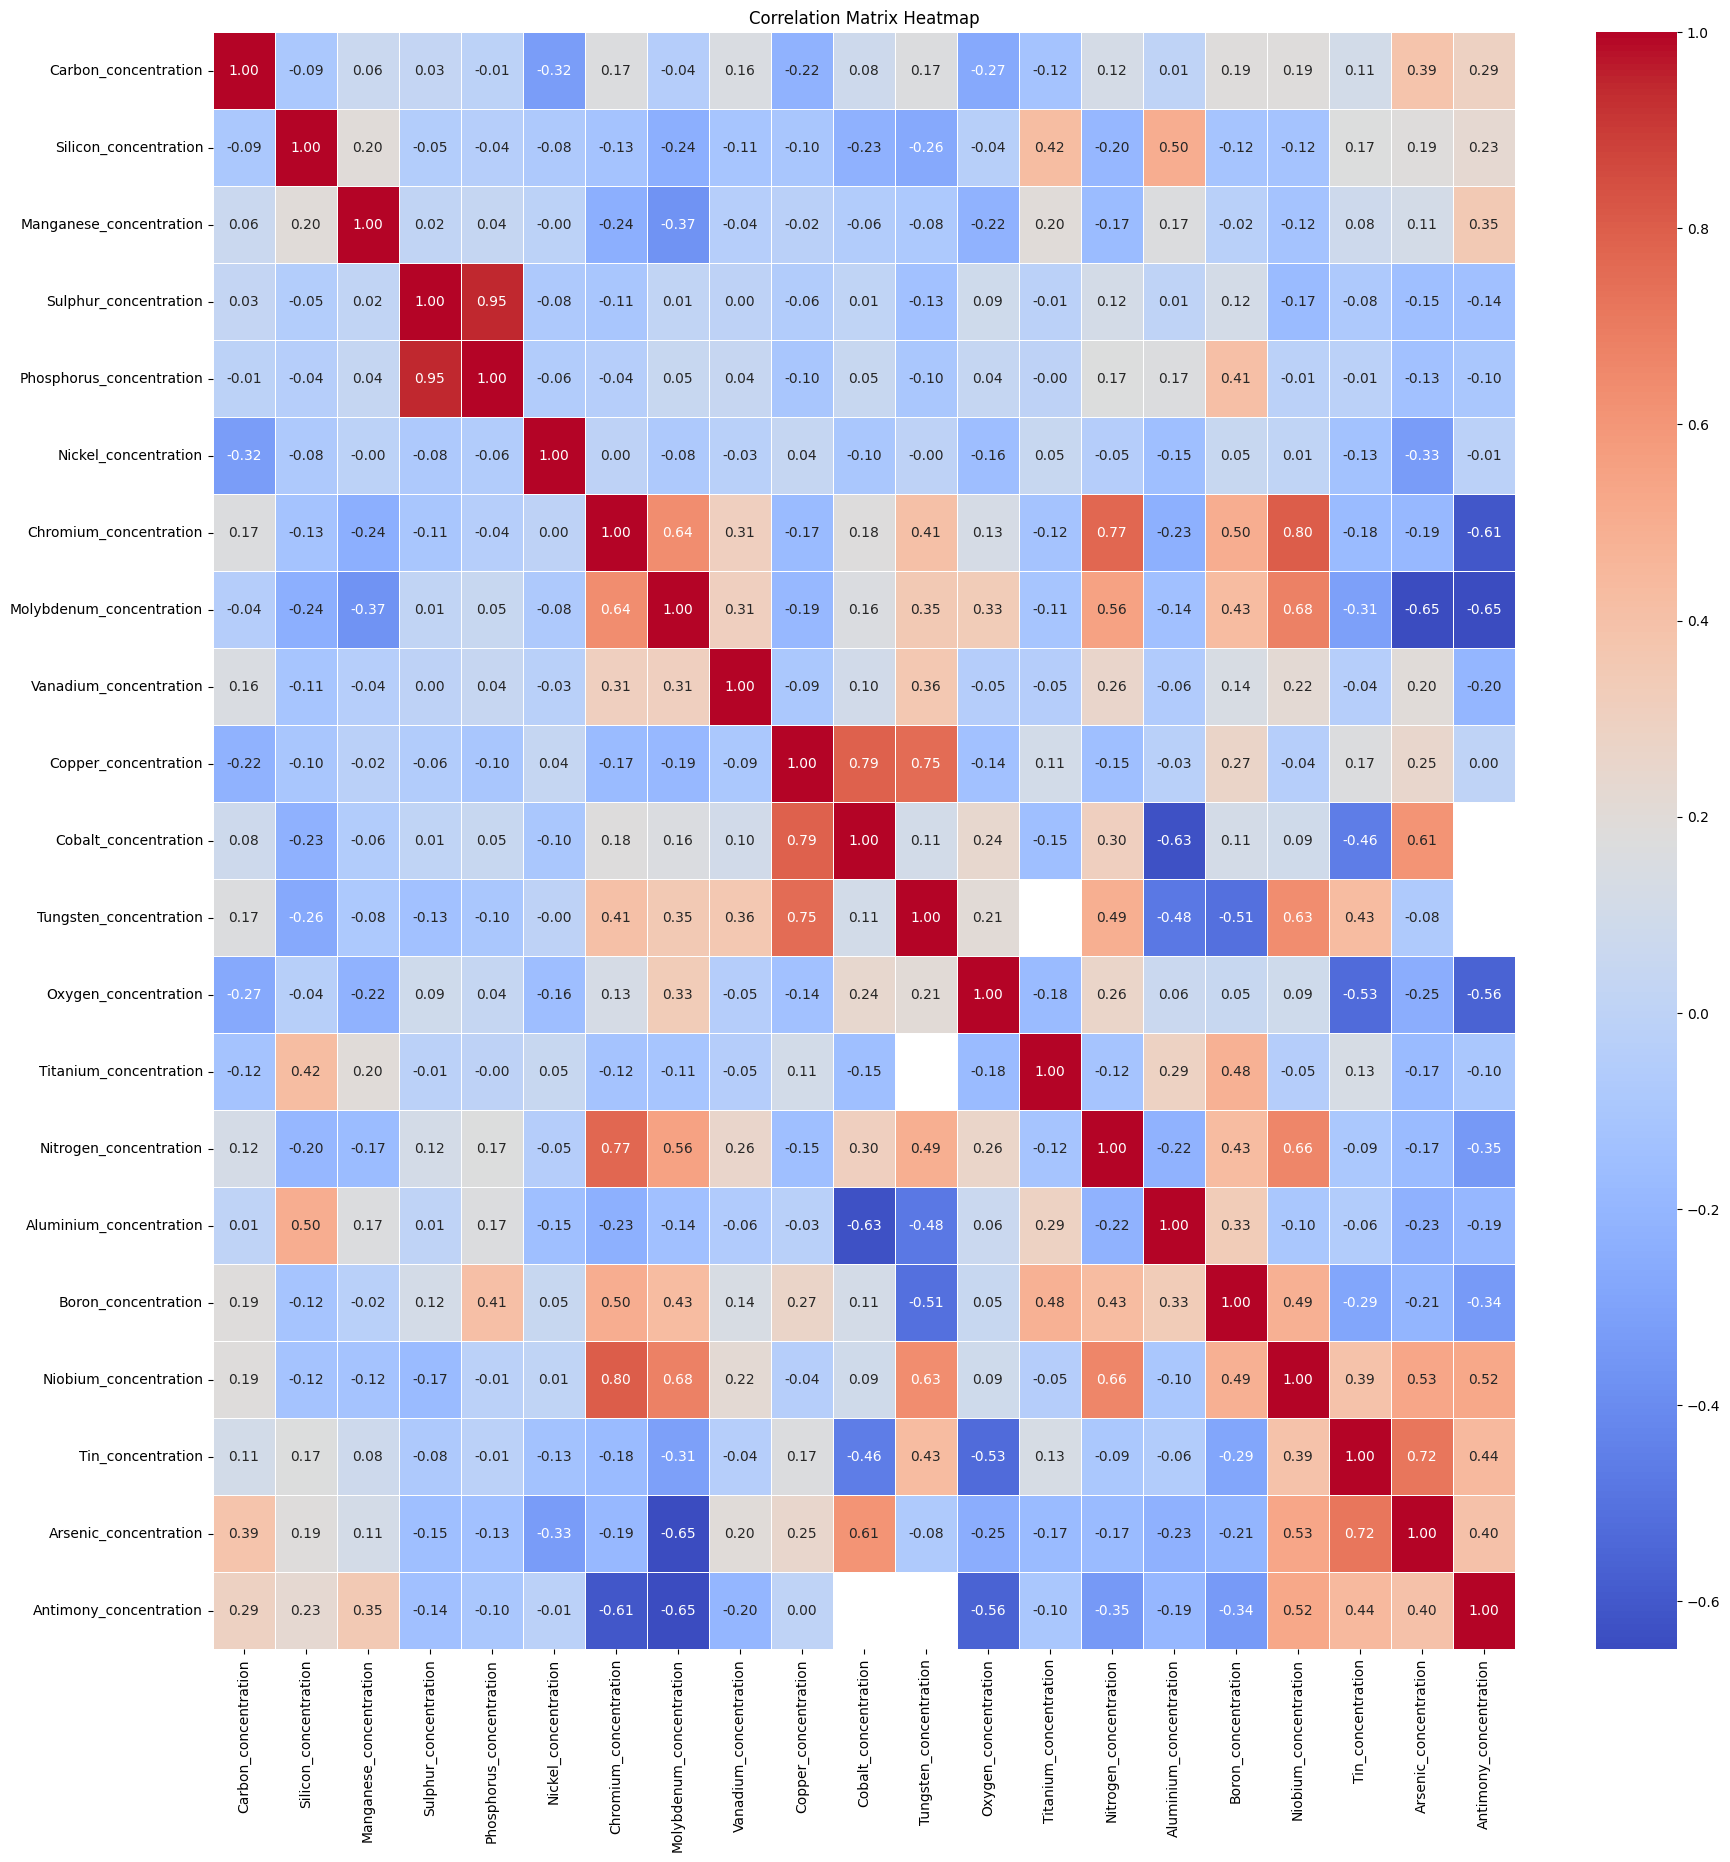

In [146]:
concentration_columns = column_names[0: 21]
correlation_matrix = data_copy[concentration_columns].corr() # By default it is pearson correlation
plt.figure(figsize=(21, 21))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<div class="alert alert-block alert-info">

- Phosphorus and Sulphur concentrations are deeply correlated

- Molybdenum and Chromimum concentrations are correlated 

The rest seems to be not so much correlated. Maybe we can use a PCA approach to reduce the number of features

According to sckit-learn library, we can use PCA with n_components=0.80 and svd_solver="full"

<b> "If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components."</b>

svd_solver = "full" means exact full SVD computes all possible singular values and vectors of the data matrix, even if they might not be needed
</div>

In [178]:
def compute_pca_on_concentrations(train_df, test_df, pca_percent_explained_variance):
    # Define concentration columns (ensure these are defined or passed in as an argument if needed)
    concentration_columns = train_df.columns  # Replace this with the actual concentration columns if needed

    # PCA approach
    pca = PCA(n_components=pca_percent_explained_variance, svd_solver="full")

    # Fit PCA on the training DataFrame and transform the data
    train_concentration_vector = pca.fit_transform(train_df[concentration_columns])

    # Transform the test DataFrame using the fitted PCA model
    test_concentration_vector = pca.transform(test_df[concentration_columns])

    # Results
    explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
    n_components = pca.n_components_  # Number of components chosen to explain the specified variance

    # Convert the transformed data back to DataFrames
    train_concentration_data = pd.DataFrame(train_concentration_vector, columns=[f'PC{i+1}' for i in range(n_components)])
    test_concentration_data = pd.DataFrame(test_concentration_vector, columns=[f'PC{i+1}' for i in range(n_components)])

    # Print results
    print(f"Number of components chosen by PCA: {n_components}")
    print(f"Explained Variance Ratio: {explained_variance_ratio}")
    print("pca result :", train_concentration_data.columns)

    return train_concentration_data, test_concentration_data

def old_compute_pca_on_concentrations(df, pca_percent_explained_variance):

    # PCA approach
    pca = PCA(n_components=pca_percent_explained_variance, svd_solver="full")

    # Fit PCA on the DataFrame and transform the data
    concentration_vector = pca.fit_transform(df[concentration_columns])

    # Results
    explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
    n_components = pca.n_components_  # Number of components chosen to explain 80% variance

    # Convert the transformed data back to a DataFrame
    concentration_data = pd.DataFrame(concentration_vector, columns=[f'PC{i+1}' for i in range(n_components)])

    # Print results
    print(f"Number of components chosen by PCA: {n_components}")
    print(f"Explained Variance Ratio: {explained_variance_ratio}")
    return concentration_data

#concentration_data = compute_pca_on_concentrations(data_copy, 0.8)


In [148]:
from typing import Literal
from sklearn.preprocessing import Normalizer, StandardScaler

def scaler(train_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list, strategy: Literal['standard', 'normalizer']):
    if strategy == 'standard':
        # Instantiate a StandardScaler
        scaler = StandardScaler()
    elif strategy == 'normalizer':
        # Instantiate a Normalizer
        scaler = Normalizer()
    else:
        raise ValueError("Invalid strategy. Choose either 'standard' or 'normalizer'.")

    # Check if categorical_columns are in the DataFrame
    if not set(categorical_columns).issubset(train_df.columns):
        raise ValueError("Some categorical columns are not present in the training DataFrame.")

    # Fit the scaler only on the categorical columns of the training data
    train_scaled = scaler.fit_transform(train_df[categorical_columns])
    test_scaled = scaler.transform(test_df[categorical_columns])

    # Convert the normalized data to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=categorical_columns, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=categorical_columns, index=test_df.index)

    # Combine scaled categorical columns with the original DataFrames (excluding the original categorical columns)
    train_final = pd.concat([train_df.drop(columns=categorical_columns), train_scaled_df], axis=1)
    test_final = pd.concat([test_df.drop(columns=categorical_columns), test_scaled_df], axis=1)

    return train_final, test_final

# Pipeline

In [186]:
OrdinalStrategies = Literal["mean", "linear"]
CategoricalStrategies = Literal["most_frequent", "logistic"]
ScalerStrategy = Literal["standard", "normalizer"]


def pipeline_training_set(*, training_set: pd.DataFrame, training_labels : pd.DataFrame, testing_set: pd.DataFrame, testing_labels : pd.DataFrame, labels_chosen : list[str], is_PCA: bool, pca_percent_explained_variance: float, 
             ordinal_strategy: OrdinalStrategies, categorical_strategy: CategoricalStrategies, scaler_strategy: ScalerStrategy):
    

    #training_set, labels = choose_labels(df, labels)

    # Structural errors
    training_set = replace_data(training_set)
    testing_set = replace_data(testing_set)

    training_set, training_labels = process_string_values(inputs=training_set, outputs=training_labels, labels_chosen=labels_chosen, strategy="random")
    testing_set, testing_labels = process_string_values(inputs=training_set, outputs=testing_labels, labels_chosen=labels_chosen, strategy="random")

    training_set = convert_to_numeric_values(training_set)
    testing_set = convert_to_numeric_values(testing_set)


    # Missing values
    ## Transform concentrations accordingly to 
    ## "The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b"
    training_set, testing_set = missing_values_sulphur_and_phosphorus(training_set, testing_set)

    training_set, testing_set = missing_values_other_concentration(training_set, testing_set)

    # One Hot Encoding
    training_set, testing_set, categorical_columns = one_hot_encoding(training_set, testing_set)

    # Missing values
    training_set, testing_set = missing_values_physical_properties(training_set, testing_set, ordinal_strategy=ordinal_strategy, categorical_strategy=categorical_strategy, categorical_columns=categorical_columns)
    



    # print(training_set.columns[training_set.isnull().any()])

    # Dimension reduction
    concentration_data_training = training_set[sulphur_and_phosphorus_columns + other_concentration_columns]
    concentration_data_testing = testing_set[sulphur_and_phosphorus_columns + other_concentration_columns]

    if is_PCA:
        # Call the PCA function with both training and testing datasets
        train_concentration_data, test_concentration_data = compute_pca_on_concentrations(
            concentration_data_training, concentration_data_testing, pca_percent_explained_variance
        )
        print(train_concentration_data)

        # Combine the PCA results with the training set
        training_set_processed = pd.concat(
            [train_concentration_data, training_set[physical_ordinal_properties_columns], training_set[categorical_columns]], 
            axis=1
        )

        print(training_set_processed)
        
        # Combine the PCA results with the testing set
        testing_set_processed = pd.concat(
            [test_concentration_data, testing_set[physical_ordinal_properties_columns], testing_set[categorical_columns]], 
            axis=1
        )
    
    # training_set_processed, testing_set_processed = scaler(training_set_processed, testing_set_processed, categorical_columns, strategy=scaler_strategy)

    # Return processed training set and labels
    return training_set_processed, testing_set_processed, training_labels, testing_labels


In [187]:
from sklearn.model_selection import train_test_split

#Selection of the targets
labels_selected = ["Yield_strength"]

#Separation of the features and the targets
X, y = choose_labels(data, labels_chosen=labels_selected)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, labels_chosen=labels_selected,categorical_strategy="most_frequent", \
                                            ordinal_strategy="mean", is_PCA=True, pca_percent_explained_variance=0.85, scaler_strategy="standard")


Number of components chosen by PCA: 3
Explained Variance Ratio: [0.49914434 0.25716336 0.13115593]
pca result : Index(['PC1', 'PC2', 'PC3'], dtype='object')
             PC1         PC2         PC3     Current    Voltage  Heat_input  \
0      67.690491 -108.362541   99.218899  170.000000  21.000000       1.000   
1     463.378402  556.066880   12.024810  170.000000  21.000000       1.000   
2      67.863957 -107.765876   99.361241  170.000000  21.000000       1.000   
3     193.407786  -91.572936 -104.339926  170.000000  21.000000       1.000   
4       4.272554  -78.246463  -68.712848  170.000000  21.000000       1.000   
...          ...         ...         ...         ...        ...         ...   
1332         NaN         NaN         NaN  300.000000  20.000000       2.080   
1396         NaN         NaN         NaN  150.000000  37.500000       1.000   
1482         NaN         NaN         NaN  450.000000  30.000000       2.025   
1638         NaN         NaN         NaN  284.821973 

/var/folders/nc/9qrt440j5_qfd7mpy2693qqh0000gn/T/ipykernel_34197/2044343595.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fals

In [181]:
X_train

,PC1,PC2,PC3,Current,Voltage,Heat_input,Interpass_temperature,Post_weld_heat_treatment_temperature,Post_weld_heat_treatment_time,Type_of_weld_FCA,...,Type_of_weld_GMAA,AC_or_DC_AC,Type_of_weld_SAA,Type_of_weld_NGSAW,Electrode_positive_or_negative_-,Electrode_positive_or_negative_+,Electrode_positive_or_negative_0,Type_of_weld_MMA,Type_of_weld_SA,AC_or_DC_DC
0,67.468567,-109.323309,98.827233,170.000000,21.000000,1.000,200.0,250.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,463.478485,555.807029,14.278392,170.000000,21.000000,1.000,200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,67.142974,-110.447857,98.556636,170.000000,21.000000,1.000,200.0,580.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,193.414574,-91.342425,-104.511152,170.000000,21.000000,1.000,200.0,250.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,4.272505,-78.071569,-68.998958,170.000000,21.000000,1.000,200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,NaN,NaN,NaN,300.000000,20.000000,2.080,150.0,690.0,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1396,NaN,NaN,NaN,150.000000,37.500000,1.000,300.0,690.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1482,NaN,NaN,NaN,450.000000,30.000000,2.025,250.0,200.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1638,NaN,NaN,NaN,284.821973,27.712054,1.000,200.0,250.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

X_train, y_train = data_with_feature_selection, labels = pipeline_training_set(training_set=X_train, labels=y_train, labels_chosen=labels_selected,categorical_strategy="most_frequent", \
                                            ordinal_strategy="mean", is_PCA=True, pca_percent_explained_variance=0.85)

In [ ]:

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

X_train, y_train = data_with_feature_selection, labels = pipeline_training_set(training_set=X_train, labels=y_train, labels_chosen=labels_selected,categorical_strategy="most_frequent", \
                                            ordinal_strategy="mean", is_PCA=True, pca_percent_explained_variance=0.85)

In [19]:
data_with_feature_selection, labels = pipeline_training_set(df=data, labels="Yield_strength", categorical_strategy="most_frequent", \
                                               ordinal_strategy="mean", is_PCA=True, pca_percent_explained_variance=0.85)

Number of components chosen by PCA: 3
Explained Variance Ratio: [0.49840943 0.2642656  0.12514074]


/var/folders/nc/9qrt440j5_qfd7mpy2693qqh0000gn/T/ipykernel_34197/2044343595.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fals

Training of the models 

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state=42)

for fold_index, (train_index, test_index)